# A/B Testing from Scratch: Frequentist Approach

Frequentist A/B testing is one of the most used and abused statistical methods in the world. This article starts with a simple problem of comparing two online ads campaigns (or teatments, user interfaces or slot machines). It outlines several useful statistical concepts and how we exploit them to solve our problem. At the end, it acknowledges some common pitfalls we face when doing a frequentist A/B test and proposes some possible solutions to a more robust A/B testing. Readers are encouraged to tinker with the widgets provided in order to explore the impacts of each parameter.

In [1]:
import numpy as np
import pandas as pd

#widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

#plots
import matplotlib.pyplot as plt
from plotnine import *

#stats
import scipy as sp
import statsmodels as sm

## Start with A Problem

A typical situation marketers (research physicians, UX researchers, or gamblers) find themselves in is that they have two variations of ads (treatments, user interfaces, or slot machines) and want to find out which one has the better performance in the long run.

Practitioners know this as A/B testing and statisticians as **hypothesis testing**. Consider the following problem. We are running an online ads campaign `A` for a period of time, but now we think a new ads variation might work better so we run an experiemnt by dividing our audience in half: one sees the existing campaign `A` whereas the other sees a new campaign `B`. Our performance metric is conversion (sales) per click (ignore [ads attribution problem](https://support.google.com/analytics/answer/1662518) for now). After the experiment ran for two months, we obtain daily clicks and conversions of each campaign and determine which campaign has the better performance.

We simulate the aforementioned problem with both campaigns getting randomly about a thousand clicks per day. The secrete we will pretend to not know is that hypothetical campaign `B` has slightly better conversion rate than `A` in the long run. With this synthetic data, we will explore some useful statistical concepts and exploit them for our frequentist A/B testing.

In [2]:
def gen_campaigns(p1,p2,nb_days,scaler,seed):
    #generate fake data
    np.random.seed(seed)
    ns = np.random.triangular(500,1000,1500,size=120).astype(int)
    np.random.seed(seed)
    es = np.random.randn(nb_days*2) / scaler

    n1 = ns[:nb_days]
    c1 = ((p1 + es[:nb_days]) * n1).astype(int)
    n2 = ns[nb_days:]
    c2 = ((p2 + es[nb_days:]) * n2).astype(int)
    conv_days = pd.DataFrame({'click_day':range(nb_days),'click_a':n1,'conv_a':c1,'click_b':n2,'conv_b':c2})

    conv_days =  conv_days[['click_day','click_a','click_b','conv_a','conv_b']]
    conv_days['cumu_click_a'] = conv_days.click_a.cumsum()
    conv_days['cumu_click_b'] = conv_days.click_b.cumsum()
    conv_days['cumu_conv_a'] = conv_days.conv_a.cumsum()
    conv_days['cumu_conv_b'] = conv_days.conv_b.cumsum()
    conv_days['cumu_rate_a'] = conv_days.cumu_conv_a / conv_days.cumu_click_a
    conv_days['cumu_rate_b'] = conv_days.cumu_conv_b / conv_days.cumu_click_b
    return conv_days

conv_days = gen_campaigns(p1 = 0.10,
                          p2 = 0.105,
                          nb_days = 60,
                          scaler=300,
                          seed = 1412) #god-mode 
conv_days.head()

,click_day,click_a,click_b,conv_a,conv_b,cumu_click_a,cumu_click_b,cumu_conv_a,cumu_conv_b,cumu_rate_a,cumu_rate_b
0,0,1254,1007,126,105,1254,1007,126,105,0.100478,0.104270
1,1,1147,549,116,60,2401,1556,242,165,0.100791,0.106041
2,2,678,955,67,98,3079,2511,309,263,0.100357,0.104739
3,3,968,764,94,82,4047,3275,403,345,0.099580,0.105344
4,4,899,969,93,99,4946,4244,496,444,0.100283,0.104618


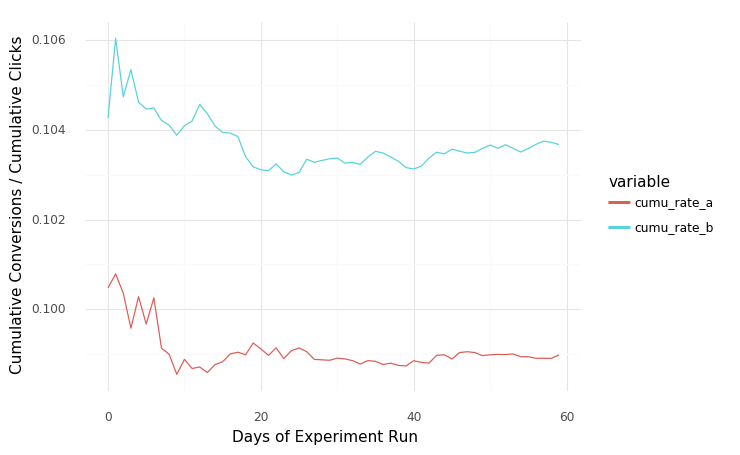

<ggplot: (-9223363267298944729)>

In [3]:
rates_df = conv_days[['click_day','cumu_rate_a','cumu_rate_b']].melt(id_vars='click_day')
g = (ggplot(rates_df, aes(x='click_day', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Days of Experiment Run') + ylab('Cumulative Conversions / Cumulative Clicks'))
g

In [4]:
#sum after 2 months
conv_df = pd.DataFrame({'campaign_id':['A','B'], 'clicks':[conv_days.click_a.sum(),conv_days.click_b.sum()],
                        'conv_cnt':[conv_days.conv_a.sum(),conv_days.conv_b.sum()]})
conv_df['conv_per'] =  conv_df['conv_cnt'] / conv_df['clicks']
conv_df

,campaign_id,clicks,conv_cnt,conv_per
0,A,59504,5890,0.098985
1,B,58944,6111,0.103675


## Random Variables and Probability Distributions

Take a step back and think about the numbers we consider in our daily routines, whether it is conversion rate of an ads campaign, the relative risk of a patient group, or sales and revenues of a shop during a given period of time. From our perspective, they have one thing in common: **we do not know exactly how they come to be**. In fact, we would not need an A/B test if we do. For instance, if we know for certain that conversion rate of an ads campaign will be `0.05 + 0.001 * number of letters in the ads`, we can tell exactly which ads to run: the one with the highest number of letters in it.

With our lack of knowledge, we do the next best thing and assume that our numbers are generated by some mathematical formula, calling them **random variables**. For instance, we might think of the probability of a click converting the same way as a coin-flip event, with the probability of converting as $p$ (say 0.1) and not converting as $1-p$ (thus 0.9). With this, we can simulate the event aka click conversion for as many times as we want:

In [5]:
def bernoulli(n,p):
    flips = np.random.choice([0,1], size=n, p=[1-p,p])
    flips_df = pd.DataFrame(flips)
    flips_df.columns = ['conv_flag']
    g = (ggplot(flips_df,aes(x='factor(conv_flag)')) + geom_bar(aes(y = '(..count..)/sum(..count..)'))  + 
        theme_minimal() + xlab('Conversion Flag') + ylab('Percentage of Occurence') +
        geom_hline(yintercept=p, colour='red') + ggtitle(f'Distribution after {n} Trials'))
    g.draw()
    print(f'Expectation: {p}\nVariance: {p*(1-p)}')
    print(f'Sample Mean: {np.mean(flips)}\nSample Variance: {np.var(flips)}')

interact(bernoulli, n=widgets.IntSlider(min=1,max=500,step=1,value=20),
        p=widgets.FloatSlider(min=0.1,max=0.9))

interactive(children=(IntSlider(value=20, description='n', max=500, min=1), FloatSlider(value=0.1, description…

<function __main__.bernoulli(n, p)>

**Probability distribution** is represented with the values of a random variable we are interested in the X-axis, and the chance of them appearing after a number of trials in the Y-axis. The distribution above is called [Bernoulli Distribution](http://mathworld.wolfram.com/BernoulliDistribution.html), usually used to model hypothetical coin flips and online advertisements. [Other distributions](https://en.wikipedia.org/wiki/List_of_probability_distributions) are used in the same manner for other types of random variables. [Cloudera](https://www.cloudera.com/) provided a [quick review](https://blog.cloudera.com/blog/2015/12/common-probability-distributions-the-data-scientists-crib-sheet/) on a few of them you might find useful.

<img src='images/distribution.png' alt='Common Probability Distributions; Cloudera'/>

## Law of Large Numbers

There are two sets of indicators of a distribution that are especially relevant to our problem: one derived theoretically and another derived from data we observed. **Law of Large Numbers (LLN)** describes the relationship of between them.

Theoretically, we can derive these values about any distribution:

* **Expectation** of a random variable $X_i$ is its long-run average dervied from repetitively sampling $X_i$ from the same distribution. Each distribution requires its own way to obtain the expectation. For our example, it is the weighted average of outcomes $X_i$ ($X_i=1$ converted; $X_i=0$ not converted) and their respective probabilities ($p$ converted; $1-p$ not converted):

\begin{align}
E[X_i] &= \mu = \sum_{i=1}^{k} p_i * X_i \\
&= (1-p)*0 + p*1 \\
&= p
\end{align}
where $k$ is number of patterns of outcomes

*  **Variance** of a random variable $X_i$ represents the expectation of how much $X_i$ deviates from its expectation, for our example formulated as:

\begin{align}
Var(X_i) &= \sigma^2 = E[(X_i-E(X_i))^2] \\
&= E[X_i^2] - E[X_i]^2 \\
&= \{(1-p)*0^2 + p*1^2\} - p^2 \\
&= p(1-p)
\end{align}

Empirically, we can also calculate their counterparts with the any amount of data we have on hand:

* **Sample Mean** is simply an average of all $X_i$ we currently have in our sample of size $n$:

\begin{align}
\bar{X} &= \frac{1}{n} \sum_{i=1}^{n} X_i
\end{align}

* **Sample Variance** is the variance based on deviation from sample mean; the $n-1$ is due to [Bessel's correction](https://en.wikipedia.org/wiki/Bessel%27s_correction#Source_of_bias) (See Appendix):

\begin{align}
s^2 &= \frac{1}{n-1} \sum_{i=1}^{n} (X_i - \bar{X})^2
\end{align}

LLN posits that when we have a large enough number of sample $n$, the sample mean will converge to expectation. This can be shown with a simple simulation:

In [6]:
def lln(n_max,p):
    mean_flips = []
    var_flips = []
    ns = []
    for n in range(1,n_max):
        flips = np.random.choice([0,1], size=n, p=[1-p,p])
        ns.append(n)
        mean_flips.append(flips.mean())
        var_flips.append(flips.var())
    flips_df = pd.DataFrame({'n':ns,'mean_flips':mean_flips,'var_flips':var_flips}).melt(id_vars='n')
    g = (ggplot(flips_df,aes(x='n',y='value',colour='variable')) + geom_line() +
        facet_wrap('~variable', ncol=1, scales='free') + theme_minimal() +
        ggtitle(f'Expectation={p:2f}; Variance={p*(1-p):2f}') + xlab('Number of Samples') +
        ylab('Value'))
    g.draw()

interact(lln, n_max=widgets.IntSlider(min=2,max=10000,step=1,value=1000),
        p=widgets.FloatSlider(min=0.1,max=0.9))

interactive(children=(IntSlider(value=1000, description='n_max', max=10000, min=2), FloatSlider(value=0.1, des…

<function __main__.lln(n_max, p)>

Notice that even though LLN does not says that sample variance will also converge to variance as $n$ grows large enough, it is also the case. Mathematically, it can be derived as follows:

\begin{align}
s^2 &= \frac{1}{n}\sum_{i=1}^{n}(X_i - \bar{X}^2) \\
&= \frac{1}{n}\sum_{i=1}^{n}(X_i - \mu)^2 \text{; as }n\rightarrow\infty\text{ }\bar{X}\rightarrow\mu\\
&=\frac{1}{n}(\sum_{i=1}^{n}{X_i}^2 - 2\mu\sum_{i=1}^{n}X_i + n\mu^2) \\
&=\frac{\sum_{i=1}^{n}{X_i}^2}{n} - \frac{2\mu\sum_{i=1}^{n}X_i}{n} + \mu^2 \\
&= \frac{\sum_{i=1}^{n}{X_i}^2}{n} - 2\mu\bar{X} + \mu^2\text{; as }\frac{\sum_{i=1}^{n}X_i}{n} = \bar{X}\\
&= \frac{\sum_{i=1}^{n}{X_i}^2}{n} - 2\mu^2 + \mu^2 = \frac{\sum_{i=1}^{n}{X_i}^2}{n} - \mu^2 \text{; as }n\rightarrow\infty\text{ }\bar{X}\rightarrow\mu\\
&= E[{X_i}^2] - E[X_i]^2 = Var(X_i) = \sigma^2
\end{align}

## Central Limit Theorem

Assuming some probability distribution for our random variable also lets us exploit another extremely powerful statistical concept: **Central Limit Theorem (CLT)**. To see CLT in action, let us simplify our problem a bit and say we are only trying to find out if a hypothetical ads campaign `C` has a conversion rate of more than 10% or not, assuming data collected so far say that `C` has 1,000 clicks and 107 conversions.

In [7]:
c_df = pd.DataFrame({'campaign_id':'C','clicks':1000,'conv_cnt':107,'conv_per':0.107},index=[0])
c_df

,campaign_id,clicks,conv_cnt,conv_per
0,C,1000,107,0.107


CLT goes as follows: 
> If $X_i$ is an independent and identically distributed (i.i.d.) random variable with expectation $\mu$ and variance $\sigma^2$ and $\bar{X_j}$ is the sample mean of $n$ samples of $X_i$ we drew as part of sample group $j$, then when $n$ is large enough, $\bar{X_j}$ will follow a [normal distribution](http://mathworld.wolfram.com/NormalDistribution.html) with with expectation $\mu$ and variance $\frac{\sigma^2}{n}$

It is a mouthful to say and full of weird symbols, so let us break it down line by line.

**If $X_i$ is an independent and identically distributed (i.i.d.) random variable with expectation $\mu$ and variance $\sigma^2$** <br/>In our case, $X_i$ is if click $i$ is coverted ($X_i=1$) or not converted ($X_i=0$) with $\mu$ as some probability that represents how likely a click will convert on average. *Independent* means that the probability of each click converting depends only on itself and not other clicks. *Identically distributed* means that the true probability of each click converting is more or less the same. We need to rely on domain knowledge to verify these assumptions; for example, in online advertisement, we would expect, at least for when working with a reputable ads network such as Criteo, that each click comes from indepdent users, as opposed to, say, a click farm where we would see a lot of clicks behaving the same way by design. Identical distribution is a little difficult to assume since we would think different demographics the ads are shown to will react differently so they might not have the same expectation.

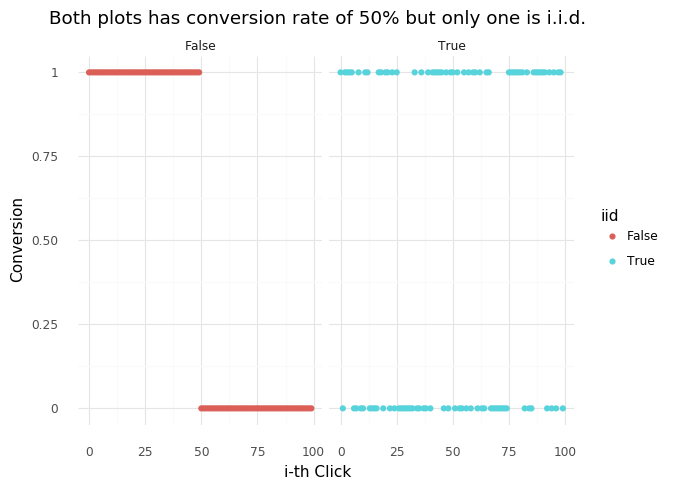

<ggplot: (8769549452264)>

In [8]:
ind_df = pd.DataFrame({'iid':[False]*100+[True]*100,
                       'order': list(range(100)) + list(range(100)),
                       'conv_flag':[1]*50+ [0]*50+ list(np.random.choice([0,1], size=100))})
g = (ggplot(ind_df,aes(x='order',y='conv_flag',color='iid')) + geom_point() +
     facet_wrap('~iid') + theme_minimal() + xlab('i-th Click') + ylab('Conversion') +
     ggtitle('Both plots has conversion rate of 50% but only one is i.i.d.'))
g

**and $\bar{X_j}$ is the sample mean of $n$ samples of $X_i$ we drew as part of sample group $j$, then**<br/>
For campaign `C`, we can think of all the clicks we observed as one sample group, which exists in parallel with an infinite number of sample groups that we have not seen yet but can be drawn from the distribution by additional data collection. This way, we calculate the sample mean as total conversions divided by total number of clicks observed during the campaign.

<img src='images/sample_group.png' alt='Sample Group in Universe'>

**when $n$ is large enough, $\bar{X_j}$ will follow a [normal distribution](http://mathworld.wolfram.com/NormalDistribution.html) with with expectation $\mu$ and variance $\frac{\sigma^2}{n}$**</br>
Here's the kicker: regardless of what distribution each $X_i$ of sample group $j$ is drawn from, as long as you have enough number of sample $n$, the sample mean of that sample group $\bar{X_j}$ will converge to a normal distribution. Try increase $n$ in the plot below and see what happens.

In [9]:
def clt(n, dist):
    n_total = n * 10000
    if dist == 'discrete uniform':
        r = np.random.uniform(size=n_total)
    elif dist =='bernoulli':
        r = np.random.choice([0,1],size=n_total,p=[0.9,0.1])
    elif dist =='poisson':
        r = np.random.poisson(size=n_total)
    else:
        raise ValueError('Choose distributions that are available')
    #generate base distribution plot
    r_df = pd.DataFrame({'r':r})
    g1 = (ggplot(r_df, aes(x='r')) + geom_histogram(bins=30) + theme_minimal() +
         xlab('Values') + ylab('Number of Samples') + 
         ggtitle(f'{dist} distribution where sample groups are drawn from'))
    g1.draw()
    
    #generate sample mean distribution plot
    normal_distribution = np.random.normal(loc=np.mean(r), scale=np.std(r) / np.sqrt(n), size=10000)
    sm_df = pd.DataFrame({'sample_means':r.reshape(-1,n).mean(1),
                          'normal_distribution': normal_distribution}).melt()
    g2 = (ggplot(sm_df, aes(x='value',fill='variable')) + 
          geom_histogram(bins=30,position='nudge',alpha=0.5) + 
          theme_minimal() + xlab('Sample Means') + ylab('Number of Sample Means') + 
         ggtitle(f'Distribution of 10,000 sample means with size {n}')) 
    g2.draw()
    

dists = ['bernoulli','discrete uniform','poisson']
interact(clt, n=widgets.IntSlider(min=1,max=100,value=1),
         dist = widgets.Dropdown(
                options=dists,
                value='bernoulli')
)

interactive(children=(IntSlider(value=1, description='n', min=1), Dropdown(description='dist', options=('berno…

<function __main__.clt(n, dist)>

The expectation and variance of the sample mean distribution can be derived as follows:

\begin{align}
E[\bar{X_j}] &= E[\frac{\sum_{i=1}^{n} X_i}{n}] \\
&= \frac{1}{n} \sum_{i=1}^{n} E[X_i] = \frac{1}{n} \sum_{i=1}^{n} \mu\\
&= \frac{n\mu}{n} = \mu \\
Var(\bar{X_j}) &= Var(\frac{\sum_{i=1}^{n} X_i}{n}) \\
&= \frac{1}{n^2} \sum_{i=1}^{n} Var(X_i) = \frac{1}{n^2} \sum_{i=1}^{n} \sigma^2\\
&= \frac{n\sigma^2}{n^2} = \frac{\sigma^2}{n} \\
\end{align}

The fact that we know this specific normal distribution of sample means has expectation $\mu$ and variance $\frac{\sigma^2}{n}$ is especially useful. Remember we want to find out whether campaign `C` **in general, not just in any sample group,** has better conversion rate than 10%. Below is that exact normal distribution based on information from our sample group (1,000 clicks) and the assumption that conversion rate is 10%:

\begin{align}
E[\bar{X_j}] &= \mu = p\\
&= 0.1 \text{; by our assumption}\\
Var(\bar{X_j}) &= \frac{\sigma^2}{n} = \frac{p*(1-p)}{n}\\
&= \frac{0.1 * (1-0.1)}{1000}\\
&= 0.0009\\
\end{align}

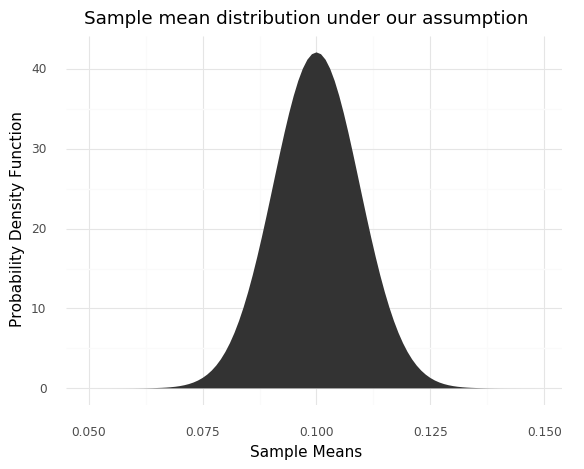

<ggplot: (8769555822526)>

In [10]:
n = c_df.clicks[0]
x_bar = c_df.conv_per[0]
p = 0.1
mu = p; variance = p*(1-p)/n; sigma = (variance)**(0.5)
# mu = 0; variance = 1; sigma = (variance)**(0.5)
x = np.arange(0.05, 0.15, 1e-3)
y = np.array([sp.stats.norm.pdf(i, loc=mu, scale=sigma) for i in x])

sm_df = pd.DataFrame({'x': x, 'y': y, 'crit':[False if i>x_bar else True for i in x]})
g = (ggplot(sm_df, aes(x='x', y='y')) + geom_area() +
      theme_minimal() + xlab('Sample Means') + ylab('Probability Density Function') + 
      ggtitle('Sample mean distribution under our assumption')) 
g

As long as we know the expectation (which we usually do as part of the assumption) and variance (which is more tricky) of the base distribution, we can use this normal distribution to model random variable from *any* distribution. That is, we can model *any* data as long as we can assume their expectation and variance. 

## Think Like A ~~Detective~~ Frequentist

In a frequentist perspective, we treat a problem like a criminal persecution. First, we assume innocence of the defendant often called **null hypothesis** (in our case that conversion rate is *less than or equal to* 10%). Then, we collect the evidence (all clicks and conversions from campaign `C`). After that, we review how *unlikely* it is that we have this evidence assuming the defendant is innocent (by looking at where our sample mean lands on the sample mean distribution). Most frequentist tests are simply saying:

>If we assume that [conversion rate]() of [ads campaign C]() has the long-run [conversion rate]() of less than or equal to [10%](), our results with sample mean [0.107]() or more extreme ones are so unlikely that they happen only [23%]() of the time, calculated by the area of the distribution with higher value than our sample mean.

Note that you can substitute the highlighted parts with any other numbers and statistics you are comparing; for instance, medical trials instead of ads campaigns and relative risks instead of converion rates.

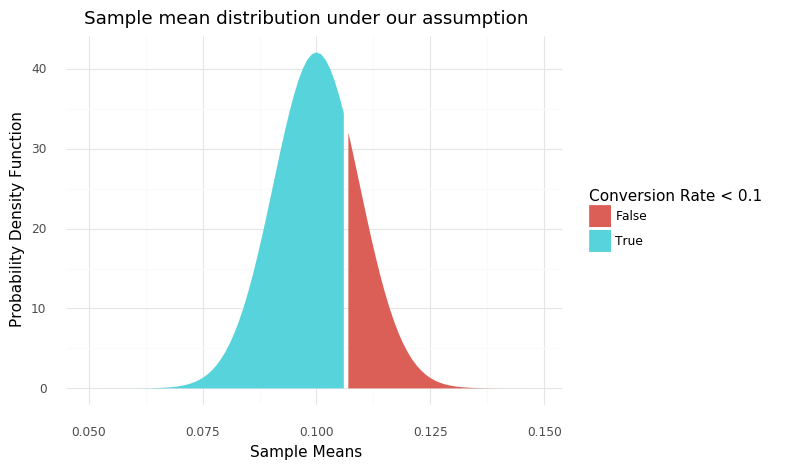

<ggplot: (8769549268386)>

In [11]:
g = (ggplot(sm_df, aes(x='x', y='y', group='crit')) + geom_area(aes(fill='crit')) +
      theme_minimal() + xlab('Sample Means') + ylab('Probability Density Function') + 
      ggtitle('Sample mean distribution under our assumption') + 
      guides(fill=guide_legend(title="Conversion Rate < 0.1"))) 
g

Whether 23% is unlikely *beyond reasonable doubt* depends on how much we are willing to tolerate the false positive rate (the percentage of innocent people you are willing to execute). By convention, a lot of practioners set this to 1-5% depending on their problems; for instance, an experiment in physics may use 1% or less because physical phenomena is highly reproducible whereas social science may use 5% because the human behaviors are more variable. This is not to be confused with **false discovery rate** which is the probability of our positive predictions turning out to be wrong. The excellent book [Statistics Done Wrong](https://www.statisticsdonewrong.com/p-value.html) has given this topic an extensive coverage that you definitely should check out (Reinhart, 2015).

This degree of acceptable unlikeliness is called **alpha** and the probability we observe is called **p-value**. We must set alpha as part of the assumption before looking at the data (the law must first state how bad an action is for a person to be executed).

## Transforming A Distribution

In the previous example of `C`, we are only interested when the conversion rate is *more than* 10% so we look only beyond the right-hand side of our sample mean (thus called **one-tailed tests**). If we were testing whether the conversion rate is *equal to* 10% or not we would be interested in both sides (thus called **two-tailed tests**). However, it is not straightforward since we have to know the equivalent position of our sample mean on the left-hand side of the distribution.

One way to remedy this is to convert the sample mean distribution to a distribution that is symmetrical around zero and has a fixed variance so the value on one side is equivalent to minus that value of the other side. **Standard normal distribution** is the normal distribution with expectation $\mu=0$ and variance $\sigma^2=1$. We convert any normal distribution to a standard normal distribution by:

1. Shift its expectation to zero. This can be done by substracting all values of a distribution by its expectation:
\begin{align}
E[\bar{X_j}-\mu] &= E[\bar{X_j}]-\mu \\
&= \mu-\mu \\
&= 0 \\
\end{align}
2. Scale its variance to 1. This can be done by dividing all values by square root of its variance called **standard deviation**:
\begin{align}
Var(\frac{\bar{X_j}}{\sqrt{\sigma^2/n}}) &= \frac{1}{\sigma^2/n}Var(\bar{X_j})\\
&= \frac{\sigma^2/n}{\sigma^2/n}\\
&=1
\end{align}

Try shifting and scaling the distribution below with different $m$ and $v$.

In [12]:
def shift_normal(m,v):
    n = c_df.clicks[0]
    x_bar = c_df.conv_per[0]
    p = 0.1
    mu = p; variance = p*(1-p)/n; sigma = (variance)**(0.5)
    x = np.arange(0.05, 0.15, 1e-3)
    y = np.array([sp.stats.norm.pdf(i, loc=mu, scale=sigma) for i in x])
    sm_df = pd.DataFrame({'x': x, 'y': y})
    
    #normalize process
    sm_df['x'] = (sm_df.x - m) / np.sqrt(v)
    sm_df['y'] = np.array([sp.stats.norm.pdf(i, loc=mu-m, scale=sigma/np.sqrt(v)) for i in sm_df.x])
    print(f'Expectation of sample mean: {mu-m}; Variance of sample mean: {variance/v}')
    g = (ggplot(sm_df, aes(x='x', y='y')) + geom_area() +
          theme_minimal() + xlab('Sample Means') + ylab('Probability Density Function') + 
          ggtitle('Shifted Normal Distribution of Sample Mean')) 
    g.draw()
    
interact(shift_normal, 
         m=widgets.FloatSlider(min=-1e-1,max=1e-1,value=1e-1,step=1e-2),
         v=widgets.FloatSlider(min=9e-5,max=9e-3,value=9e-5,step=1e-4, readout_format='.5f'))

interactive(children=(FloatSlider(value=0.1, description='m', max=0.1, min=-0.1, step=0.01), FloatSlider(value…

<function __main__.shift_normal(m, v)>

By shifting and scaling, we can find out where `C`'s sample mean of 0.107 lands on the X-axis of a standard normal distribution:
\begin{align}
\bar{Z_j} &= \frac{\bar{X_j} - \mu}{\sigma / \sqrt{n}} \\
&= \frac{0.107 - 0.1}{0.3 / \sqrt{1000}} \approx 0.7378648\\
\end{align}

With $\bar{Z_j}$ and $-\bar{Z_j}$, we can calculate the probability of falsely rejecting the null hypotheysis, or p-value, as the area in red, summing up to approximately 46%. This is most likely too high a false positive rate anyone is comfortable with (no one believes a pregnancy test that turns out positive for 46% of the people who are not pregnant), so we fail to reject the null hypothesis that conversion rate of `C` is equal to 10%. 

If someone asks a frequentist for an opinion, they would probably say that they cannot disprove `C` has conversion rate of 10% in the long run. If they were asked to choose an action, they would probably go with the course of action that assumes `C` has a conversion rate of 10%.

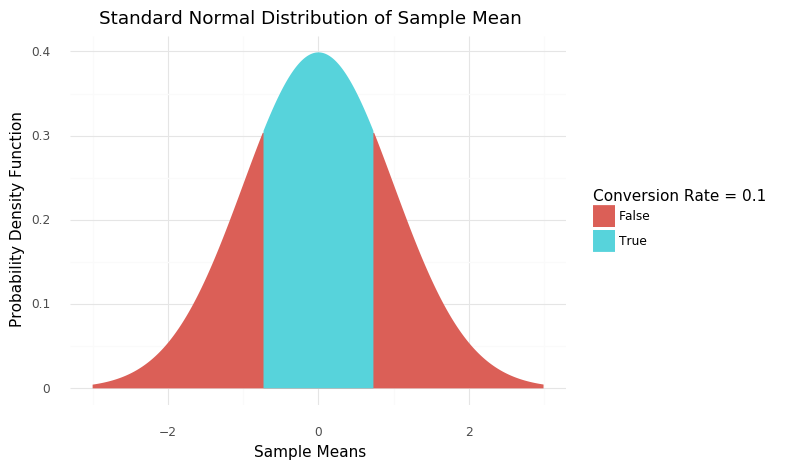

In [13]:
n = c_df.clicks[0]
x_bar = c_df.conv_per[0]
p = 0.1; mu = p; variance = p*(1-p)/n; sigma = (variance)**(0.5)
x_bar_norm = (x_bar - mu) / sigma

def standard_normal(x_bar_norm, legend_title):
    x_bar_norm = abs(x_bar_norm)
    x = np.arange(-3, 3, 1e-2)
    y = np.array([sp.stats.norm.pdf(i, loc=0, scale=1) for i in x])
    sm_df = pd.DataFrame({'x': x, 'y': y})

    #normalize process
    sm_df['crit'] = sm_df.x.map(lambda x: False if ((x<-x_bar_norm)|(x>x_bar_norm)) else True)
    g = (ggplot(sm_df, aes(x='x', y='y',group='crit')) + geom_area(aes(fill='crit')) +
          theme_minimal() + xlab('Sample Means') + ylab('Probability Density Function') + 
          ggtitle('Standard Normal Distribution of Sample Mean') +
          guides(fill=guide_legend(title=legend_title))) 
    g.draw()

standard_normal(x_bar_norm, "Conversion Rate = 0.1")

## Z-test and More

With CLT and standard normal distribution (sometimes called **Z-distribution**), we now have all the tools for one of the most popular and useful statistical hypothesis test, the **Z-test**. In fact we have already done it with the hypothetical campaign `C`. But let us go back to our original problem of comparing the long-run conversion rates of `A` and `B`. Let our null hypothesis be that they are equal to each other and alpha be 0.05 (we are comfortable with false positive rate of 5%).

In [14]:
conv_df

,campaign_id,clicks,conv_cnt,conv_per
0,A,59504,5890,0.098985
1,B,58944,6111,0.103675


We already know how to compare a random variable to a fixed value, but now we have two random variables from two ads campaign. We get around this by comparing **the difference of their sample mean** $\bar{X_\Delta} = \bar{X_{A}} - \bar{X_{B}}$ to 0. This way, our null hypothesis states that there is no difference between the long-run conversion rates of these campaigns. Through another useful statistical concept, we also know that the variance of $\bar{X_\Delta}$ is the sum of sample mean variances of $\bar{X_\text{A}}$ and $\bar{X_\text{B}}$ (Normal Sum Theorem; [Lemon, 2002](https://www.goodreads.com/book/show/3415974-an-introduction-to-stochastic-processes-in-physics)).

Thus, we can calculate the **test statistic** or, specifically for Z-test, **Z-value** as follows:

\begin{align}
\bar{Z_\Delta} &= \frac{\bar{X_\Delta}-\mu}{\sqrt{\frac{\sigma^2_\text{A}}{n_\text{A}} + \frac{\sigma^2_\text{B}}{n_\text{B}}}} \\
&= \frac{\bar{X_\Delta}-\mu}{\sqrt{\sigma^2_\text{pooled} * (\frac{1}{n_\text{A}} + \frac{1}{n_\text{B}})}} 
\end{align}

Since we are assuming that `A` and `B` has the same conversion rate, their variance is also assumed to be the same:

$$\sigma^2_{A} = \sigma^2_{B} = \sigma_\text{pooled} = p * (1-p)$$

where $p$ is the total conversions of both campaigns divided by their clicks (**pooled probability**).

In light of the Z-value calculated from our data, we found that p-value of rejecting the null hypothesis that conversion rates of `A` and `B` are equal to each other is less than 3%, lower than our acceptable false positive rate of 5%, so we reject the null hypothesis that they perform equally well. The result of the test is **statistically significant**; that is, it is unlikely enough for us given the null hypothesis.

Z-value: -2.6744183909575856; p-value: 0.00748589934574917


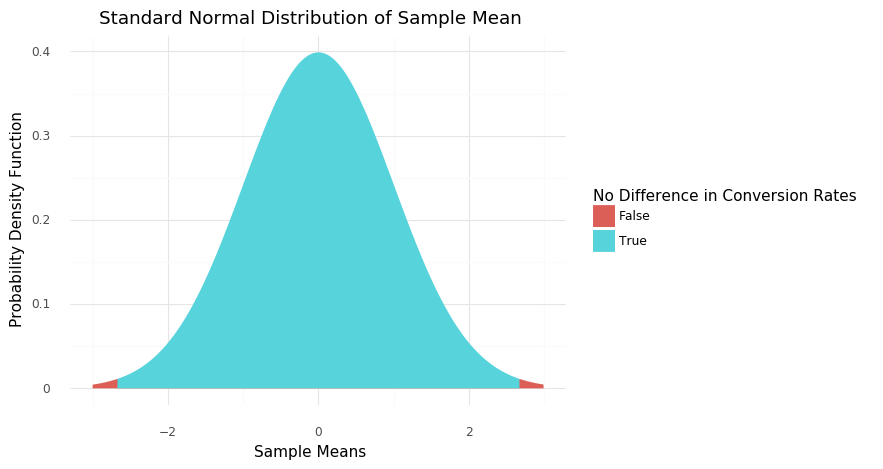

In [15]:
def proportion_test(c1, c2, n1, n2, mode = 'two_sided'):
    p = (c1+c2) / (n1+n2)
    p1 = c1 / n1
    p2 = c2 / n2
    z = (p1-p2) / np.sqrt(p*(1-p)*(1/n1 + 1/n2))
    if mode=='two_sided':
        p = 2*(1-sp.stats.norm.cdf(abs(z)))
    elif mode=='one_sided':
        p = 1-sp.stats.norm.cdf(abs(z))
    else:
        raise ValueError('Available modes are `one_sided` and `two_sided`')
    return z, p

z_value, p_value = proportion_test(c1=conv_df.conv_cnt[0], c2=conv_df.conv_cnt[1],
                n1=conv_df.clicks[0], n2=conv_df.clicks[1], mode='two_sided')
print(f'Z-value: {z_value}; p-value: {p_value}')

standard_normal(z_value, "No Difference in Conversion Rates")

This rationale extends beyond comparing proportions such as conversion rates. For instance, we can also compare revenues of two different stores, assuming they are i.i.d. However in this case, we do not know the variance of the base distribution $\sigma^2$, as it cannot be derived from our assumption (variance of Bernoulli distribution is $p*(1-p)$ but store revenues are not modelled after a coin flip). The test statistic then is created with sample variance $s^2$ based on our sample group and follows a slightly modified version of standard normal distribution (see [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)). Your test statistics and sample mean distributions may change, but bottom line of frequentist A/B test is exploiting CLT and frequentist reasoning.

## Confidence Intervals

Notice that we can calculate p-value from Z-value and vice versa. This gives us another canny way to look at the problem; that is, we can calculate the intervals where there is an arbitrary probability, say 95%, that sample mean of `A` or `B` will fall into. We call it **confidence interval**. You can see that despite us rejecting the null hypothesis that their difference is zero, the confidence intervals of both campaigns can still overlap. 

Try changing the number of conversion rate and clicks of each group as well as the alpha to see what changes in terms of p-value of Z-test and confidence intervals. You will see that the sample mean distribution gets "wider" as we have fewer samples in a group. Intuitively, this makes sense because the fewer clicks you have collected, the less information you have about true performance of an ads campaign and less confident you are about where it should be. So when designing an A/B test, you should plan to have similar number of sample between both sample groups in order to have similarly distributed sample means.

In [16]:
def ci_plot(p1,p2,n1,n2,alpha=0.05):
    p = (p1*n1+p2*n2) / (n1+n2)
    se1 = np.sqrt(p1*(1-p1)/n1)
    se2 = np.sqrt(p2*(1-p2)/n2)
    z = sp.stats.norm.ppf(1-alpha/2)
    x1 = np.arange(p1-3*se1,p1+3*se1,1e-4)
    x2 = np.arange(p2-3*se2,p2+3*se2,1e-4)
    y1 = np.array([sp.stats.norm.pdf(i, loc=p1, scale=np.sqrt(p1*(1-p1)/n1)) for i in x1])
    y2 = np.array([sp.stats.norm.pdf(i, loc=p2, scale=np.sqrt(p2*(1-p2)/n2)) for i in x2])
    sm_df = pd.DataFrame({'campaign_id': ['Campaign A'] * len(x1) + ['Campaign B'] * len(x2),
        'x':np.concatenate([x1,x2]),'y':np.concatenate([y1,y2])})
    
    #test
    z_value, p_value = proportion_test(p1*n1, p2*n2, n1,n2, mode='two_sided')
    print(f'Z-value: {z_value}; p-value: {p_value}')
    
    g = (ggplot(sm_df, aes(x='x', y='y', fill='campaign_id')) + geom_area(alpha=0.5) +
      theme_minimal() + xlab('Sample Mean Distribution of Each Campaign') + 
      ylab('Probability Density Function') + 
      geom_vline(xintercept=[p1+se1*z,p1-se1*z], colour='red') +
      geom_vline(xintercept=[p2+se2*z,p2-se2*z], colour='blue') +
      ggtitle(f'Confident Intervals at alpha={alpha}')) 
    g.draw()
    
interact(ci_plot, 
         p1 = widgets.FloatSlider(min=0,max=1,value=conv_df.conv_cnt[0] / conv_df.clicks[0],
                                 step=1e-3,readout_format='.5f'),
         p2 = widgets.FloatSlider(min=0,max=1,value=conv_df.conv_cnt[1] / conv_df.clicks[1],
                                 step=1e-3,readout_format='.5f'),
         n1 = widgets.IntSlider(min=10,max=70000,value=conv_df.clicks[0]),
         n2 = widgets.IntSlider(min=10,max=70000,value=conv_df.clicks[1]),
         alpha = widgets.FloatSlider(min=0,max=1,value=0.05),
         campaign_ids = conv_df.campaign_id)

interactive(children=(FloatSlider(value=0.09898494218876042, description='p1', max=1.0, readout_format='.5f', …

<function __main__.ci_plot(p1, p2, n1, n2, alpha=0.05)>

## Any Hypothesis Test Is Statistically Significant with Enough Samples

Because we generated the data, we know that conversion rate of campaign `A` (10%) is about 95% that of campaign `B` (10.5%). If we go with our gut feeling, most of us would say that they are practically the same; yet, our Z-test told us that they are different. The reason for this becomes apparent graphically when we decrease the number of clicks for both campaigns in the plot above. The Z-test stops becoming significant when both campaigns have about 50,000 clicks each, even though they still have exactly the same conversion rate. The culprit is our Z-value calculated as:

\begin{align}
\bar{Z_\Delta} &= \frac{\bar{X_\Delta}-\mu}{\sqrt{\sigma^2_\text{pooled} * (\frac{1}{n_\text{A}} + \frac{1}{n_\text{B}})}} 
\end{align}

Notice number of clicks $n_\text{A}$ and $n_\text{B}$ hiding in the denominator. Our test statistics $\bar{Z_\Delta}$ will go infinitely higher as long as we collect more clicks. If both campaigns `A` and `B` have one million clicks each, the difference of as small as 0.1% will be detected as statistically significant. Try adjusting the probabilities $p1$ and $p2$ in the plot below and see if the area of statistical significance expands or contracts as the difference between the two numbers changes.


In [17]:
def significance_plot(p1,p2):
    n1s = pd.DataFrame({'n1':[10**i for i in range(1,7)],'k':0})
    n2s = pd.DataFrame({'n2':[10**i for i in range(1,7)],'k':0})
    ns = pd.merge(n1s,n2s,how='outer').drop('k',1)
    ns['p_value'] = ns.apply(lambda row: proportion_test(p1*row['n1'], p2*row['n2'],row['n1'],row['n2'])[1], 1)
    g = (ggplot(ns,aes(x='factor(n1)',y='factor(n2)',fill='p_value')) + geom_tile(aes(width=.95, height=.95)) +
        geom_text(aes(label='round(p_value,3)'), size=10)+ theme_minimal() +
        xlab('Number of Samples in A') + ylab('Number of Samples in B') +
        guides(fill=guide_legend(title="p-value")))
    g.draw()

interact(significance_plot, 
         p1 = widgets.FloatSlider(min=0,max=1,value=conv_df.conv_cnt[0] / conv_df.clicks[0],
                                 step=1e-3,readout_format='.5f'),
         p2 = widgets.FloatSlider(min=0,max=1,value=conv_df.conv_cnt[1] / conv_df.clicks[1],
                                 step=1e-3,readout_format='.5f'))

interactive(children=(FloatSlider(value=0.09898494218876042, description='p1', max=1.0, readout_format='.5f', …

<function __main__.significance_plot(p1, p2)>

More practically, look at cumulative conversion rates and z-values of `A` and `B` on a daily basis. Every day that we check the results based on cumulative clicks and conversions, we will come up with a different test statistic and p-value. Difference in conversion rates seem to stabilize after 20 days; however, notice that if you stop the test at day 25 or so, you would say it is NOT statistically significant, whereas if you wait a little longer, you will get the opposite result. The only thing that changes as time goes on is that we have more samples.

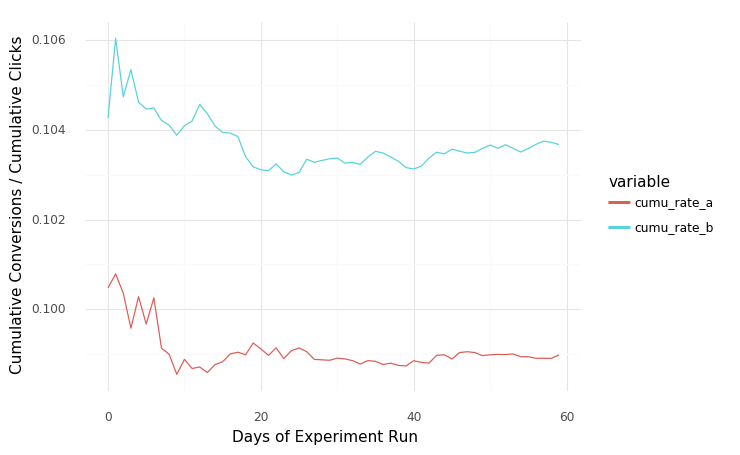

<ggplot: (8769551220856)>

In [18]:
g = (ggplot(rates_df, aes(x='click_day', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Days of Experiment Run') + ylab('Cumulative Conversions / Cumulative Clicks'))
g

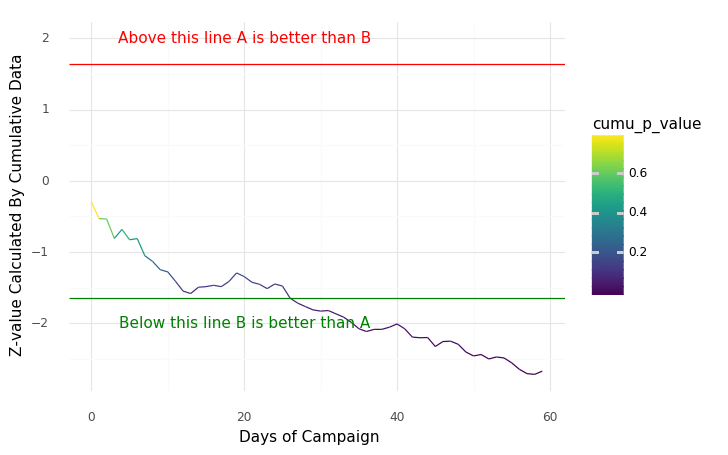

<ggplot: (8769549286895)>

In [19]:
#test
conv_days['cumu_z_value'] = conv_days.apply(lambda row: proportion_test(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b'], mode='two_sided')[0],1)
conv_days['cumu_p_value'] = conv_days.apply(lambda row: proportion_test(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b'], mode='two_sided')[1],1)

#plot
g = (ggplot(conv_days, aes(x='click_day',y='cumu_z_value',color='cumu_p_value')) + geom_line() + theme_minimal() +
    xlab('Days of Campaign') + ylab('Z-value Calculated By Cumulative Data') +
    geom_hline(yintercept=[sp.stats.norm.ppf(0.95),sp.stats.norm.ppf(0.05)], color=['red','green']) +
    annotate("text", label = "Above this line A is better than B", x = 20, y = 2, color = 'red') +
    annotate("text", label = "Below this line B is better than A", x = 20, y = -2, color = 'green'))
g

## Minimum Detectable Effect and Required Sample Size

We argue that this too-big-to-fail phenomena among sample groups is especially dangerous in the context of today's "big data" society. Gone are the days where statistical tests are done among two control groups of 100 people each using paper survey forms. Now companies are performning A/B testing between ad variations that could have tens of thousands or more samples (impressions or clicks), and potentially all of them will be "statistically significant". 

One way to remedy this is to do what frequentists do best: make more assumptions, more specifically **two** more. First, if we want to find out whether `B` has *better* conversion than `A`, we do not only make the null hypothesis (that `B` performs worse than or equally well as `A`) but **minimally by how much**. We can set **mininum detectable effect** as the smallest possible difference that would be worth investing the time and money in one campaign over the other; let say that from experience we think it is 1%. We then ask:

> What is the mininum number of samples in a sample group (clicks in a campaign) should we have in order to reject the null hypothesis when the difference in sample means is [1%]()?

The required number of samples in each group $n$ in order for the test to reject a minimum detectable effect $\text{MDE}$ at a certain alpha is:
\begin{align}
Z_{\alpha} &= \frac{\text{MDE}-\mu}{\sqrt{\sigma^2 * (\frac{1}{n} + \frac{1}{n})}} \\
\frac{2\sigma^2}{n} &= (\frac{\text{MDE}}{Z_{\alpha}})^2 \\
n &= 2(\frac{Z_{\alpha} \sigma}{\text{MDE}})^2
\end{align}

Second, we make yet another crucial assumption about **the variance $\sigma^2$ we expect**. Remember we used to estimate the variance by using the pooled probability of our sample groups, but here we have not even started the experiments. In a conventional A/B testing scenario, we are testing whether an experimental variation is better than the existing one, so one choice is **using sample variance of a campaign you are currently running**; for instance, if `A` is our current ads and we want to know if we should change to `B`, then we will use conversion rate of `A` from past time period to calculate the variance, say 10%.

Let us go back in time before we even started our 2-month-long test between campaign `A` and `B`. Now we assume not only acceptable false positive rate alpha of 0.05 but also minimum detectable effect of 1% and expected variance of $\sigma^2 = 0.1 * (1-0.1) = 0.09$, then we calculate that the minimum number of samples we should collect for each campaign. You can see that should we have done that we would have not been able to reject the null hypothesis, and stuck with campaign `A` going forward.

The upside is that now we only have to run the test for about 5 days instead of 60 days assuming every day is the same for the campaigns (no peak traffic on weekends, for instance). The downside is that our null hypothesis gets much more specific with not only one but three assumptions:

* Long-run conversion rate of `B` is no better than `A`'s
* The difference that will matter to us is at least 1%
* The expected variance conversion rates is $\sigma^2 = 0.1 * (1-0.1) = 0.09$

This fits many A/B testing scenarios since we might not want to change to a new variation even though it is better but not so much that we are willing to invest our time and money to change our current setup. Try adjusting $\text{MDE}$ and $\sigma$ in the plot below and see how the number of required samples change.

In [20]:
def required_samples(mde, p, p_value, mode='one_sided'):
    variance = p*(1-p)
    if mode=='two_sided':
        z = sp.stats.norm.ppf(1-p_value/2)
    elif mode=='one_sided':
        z = sp.stats.norm.ppf(1-p_value)
    else:
        raise ValueError('Available modes are `one_sided` and `two_sided`')
    return 2*variance*(z/mde)**2


def plot_required_samples(mde, p, p_value, mode='one_sided'):
    minimum_samples = required_samples(mde, p, p_value, mode)
    g = (ggplot(conv_days, aes(x='cumu_click_a',y='cumu_z_value',color='cumu_p_value')) + geom_line() + 
        theme_minimal() +
        xlab('Number of Samples per Campaign') + ylab('Z-value Calculated By Cumulative Data') +
        geom_hline(yintercept=[sp.stats.norm.ppf(0.95),sp.stats.norm.ppf(0.05)], color=['red','green']) +
        annotate("text", label = "Above this line A is better than B", x = 30000, y = 2, color = 'red') +
        annotate("text", label = "Below this line B is better than A", x = 30000, y = -2, color = 'green') +
        annotate("text", label = f'Minimum required samples at MDE {mde}={int(minimum_samples)}', x = 30000, y = 0,) +
        geom_vline(xintercept=minimum_samples))
    g.draw()

interact(plot_required_samples, mde = widgets.FloatSlider(min=0.001,max=0.01, value=0.01, step=1e-3,
                                                          readout_format='.5f'),
         p = widgets.FloatSlider(min=0.,max=1, value=0.1, step=1e-3, readout_format='.5f'),
         p_value = widgets.FloatSlider(min=0.01,max=0.1, value=0.05, step=1e-3, readout_format='.5f'),
         mode = widgets.Dropdown(options=['one_sided','two_sided'], value='one_sided')
        )

interactive(children=(FloatSlider(value=0.01, description='mde', max=0.01, min=0.001, readout_format='.5f', st…

<function __main__.plot_required_samples(mde, p, p_value, mode='one_sided')>

## You Will Get A Statistically Significant Result If You Try Enough Times

The concept p-value represents is false positive rate of our test, that is, how unlikely it is to observe our sample groups given that they do not have different conversion rates in the long run. Let us re-simulate our campaigns `A` and `B` to have equal expectation of 10%. If we apply our current method, we can be comfortably sure we will not get statistical significance (unless we have an extremely large number of samples).

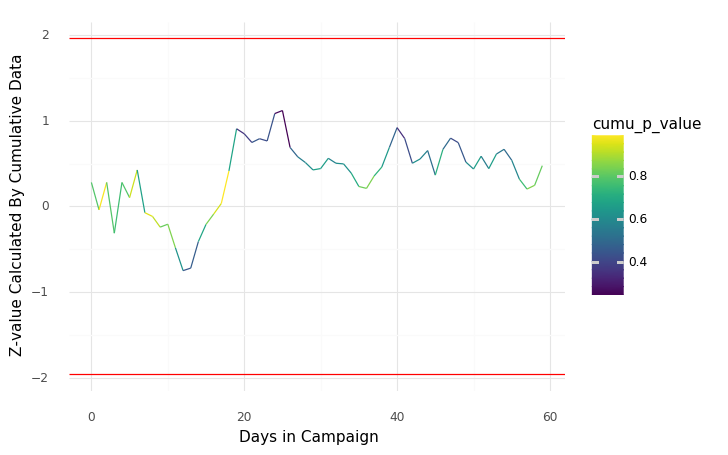

<ggplot: (-9223363267305507377)>

In [21]:
conv_days = gen_campaigns(p1 = 0.10,
                          p2 = 0.10,
                          nb_days = 60,
                          scaler=100,
                          seed = 1412) #god-mode 

conv_days['cumu_z_value'] = conv_days.apply(lambda row: proportion_test(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b'], mode='two_sided')[0],1)
conv_days['cumu_p_value'] = conv_days.apply(lambda row: proportion_test(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b'], mode='two_sided')[1],1)
conv_days['z_value'] = conv_days.apply(lambda row: proportion_test(row['conv_a'], 
                                                                   row['conv_b'],row['click_a'], 
                                                                   row['click_b'], mode='two_sided')[0],1)
conv_days['p_value'] = conv_days.apply(lambda row: proportion_test(row['conv_a'], 
                                                                   row['conv_b'],row['click_a'], 
                                                                   row['click_b'], mode='two_sided')[1],1)
g = (ggplot(conv_days, aes(x='click_day',y='cumu_z_value',color='cumu_p_value')) + geom_line() + theme_minimal() +
    xlab('Days in Campaign') + ylab('Z-value Calculated By Cumulative Data') +
    geom_hline(yintercept=[sp.stats.norm.ppf(0.975),sp.stats.norm.ppf(0.025)], color=['red','red']))
g

Another approach is instead of doing the test only once, we **do it every day using clicks and conversions of that day alone**. We will have 60 tests where 3 of them give statistically significant results that `A` and `B` have different conversion rates in the long run. The fact that we have exactly 5% of the tests turning positive despite knowing that none of them should is not a coincidence. The Z-value is calculated based on alpha of 5%, which means even if there is no difference at 5% of the time we perform this test with this specific set of assumptions we will still have a positive result ([Obligatory relevant xkcd strip](https://xkcd.com/882/); Munroe, n.d.).

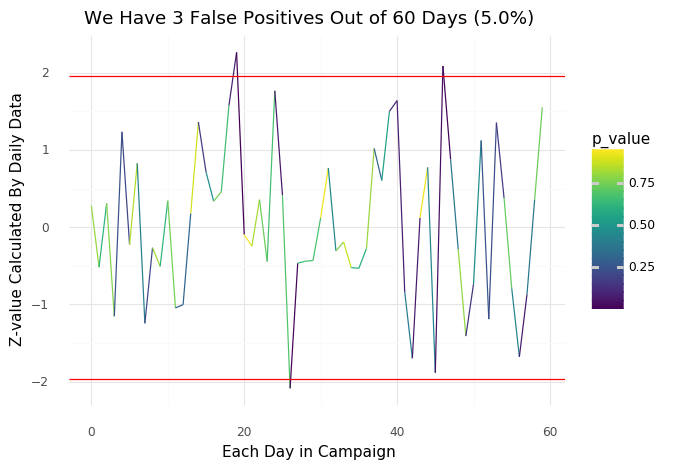

<ggplot: (-9223363267298958350)>

In [22]:
g = (ggplot(conv_days, aes(x='click_day',y='z_value',color='p_value')) + geom_line() + theme_minimal() +
    xlab('Each Day in Campaign') + ylab('Z-value Calculated By Daily Data') +
    geom_hline(yintercept=[sp.stats.norm.ppf(0.975),sp.stats.norm.ppf(0.025)], color=['red','red']) +
    ggtitle(f'We Have {(conv_days.p_value<0.05).sum()} False Positives Out of {conv_days.shape[0]} Days ({100*(conv_days.p_value<0.05).sum()/conv_days.shape[0]}%)'))
g

Not many people will test online ads campaigns based on daily data, but many researchers perform repeated experiments and by necessity repeated A/B tests as shown above. If you have a reason to believe that sample groups from different experiments have the same distribution, you might consider grouping them together and perform one large test as usual. Otherwise, you can tinker the assumption of how much false positive you can tolerate. One such approach, among [others](https://en.wikipedia.org/wiki/Multiple_comparisons_problem), is the [Bonferroni correction](http://mathworld.wolfram.com/BonferroniCorrection.html). It scales your alpha down by the number of tests you perform to make sure that your false positive rate stays at most your original alpha. In our case, if we cale our alpha as$\alpha_{\text{new}}=\frac{0.05}{60} \approx 0.0008$, we will have the following statistically non-significant results.

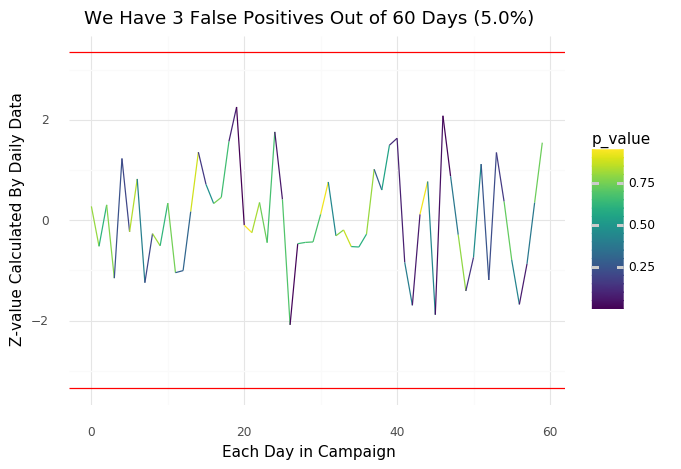

<ggplot: (-9223363267305675825)>

In [23]:
g = (ggplot(conv_days, aes(x='click_day',y='z_value',color='p_value')) + geom_line() + theme_minimal() +
    xlab('Each Day in Campaign') + ylab('Z-value Calculated By Daily Data') +
    geom_hline(yintercept=[sp.stats.norm.ppf(1-0.0008/2),sp.stats.norm.ppf(0.0008/2)], color=['red','red']) +
    ggtitle(f'We Have {(conv_days.p_value<0.05).sum()} False Positives Out of {conv_days.shape[0]} Days ({100*(conv_days.p_value<0.05).sum()/conv_days.shape[0]}%)'))
g

## Best Practices

To the best of our knowledge, the most reasonable and practical way to perform a frequentist A/B test is to know your assumptions, including but not limited to:

* What distribution should your data be assumed to be drawn from? In many cases, we use Bernoulli distribution for proportions, Poisson distribution for counts and normal distribution for real numbers.
* Are you comparing your sample group to a fixed value or another sample group?
* Do you want to know if the expectation of the sample group is equal to, more than or less than its counterpart?
* What is the minimum detectable effect and how many samples should you collect? What is a reasonable variance to assume in order to calculated required sample size?
* What is the highest false positive rate $\alpha$ that you can accept?

With these assumptions cleared, you can most likely create a test statistics, then with frequentist reasoning, you can determine if the sample group you collected are unlikely enough that you would reject your null hypothesis because of it.

## References

* Lemons, D. S. (2002). An introduction to stochastic processes in physics. Baltimore: Johns Hopkins University Press.
Normal Sum Theorem; p34
* Munroe, Randall (n.d.). HOW TO Absurd Scientific Answers toCommon Real-world Problems. Retrieved from https://xkcd.com/882/
* Reinhart, A. (2015, March 1). The p value and the base rate fallacy. Retrieved from https://www.statisticsdonewrong.com/p-value.html
* [whuber](https://stats.stackexchange.com/users/919/whuber) (2017). Can a probability distribution value exceeding 1 be OK?. Retrieved from https://stats.stackexchange.com/q/4223

## Appendix

### Bessel's Correction for Sample Variance

Random variables can be thought of as estimation of the real values such as sample variance is an estimation of variance from the "true" distribution. An estimator is said to be **biased** when its expectation is not equal to the true value (not to be confused with LLN where the estimator itself approaches the true value as number of samples grows).

We can repeat the experiment we did for LLN with sample mean and true mean, but this time we compare how biased version ($\frac{1}{n} \sum_{i=1}^{n} (X_i - \bar{X})^2$) and unbiased version ($\frac{1}{n-1} \sum_{i=1}^{n} (X_i - \bar{X})^2$) of sample variance approach true variance as number of sample groups grow. Clearly, we can see that biased sample variance normally underestimates the true variance.

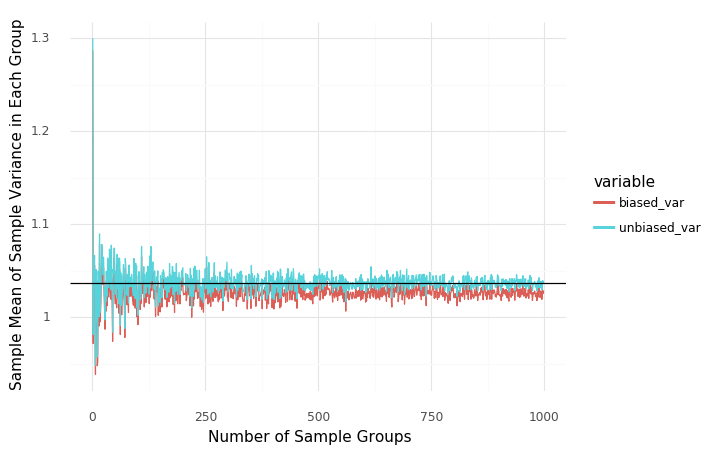

<ggplot: (8769551219748)>

In [24]:
def var(x, dof=0):
    n = x.shape[0]
    mu = np.sum(x)/n
    return np.sum((x - mu)**2) / (n-dof)

n_total = 10000 #total number of stuff
n_sample = 100 #number of samples per sample group
sg_range = range(1,1000) #number of sample groups to take average of sample variances from
r = np.random.normal(loc=0,scale=1,size=n_total) #generate random variables based on Z distribution
pop_var = var(r) #true variance of the population

mean_s_bs = []
mean_s_us = []

for n_sg in sg_range:
    s_bs = []
    s_us =[]
    for i in range(n_sg):
        sg = np.random.choice(r,size=n_sample,replace=False)
        s_bs.append(var(sg)) #biased sample variance
        s_us.append(var(sg,1)) #unbiased sample variance
    mean_s_bs.append(np.mean(s_bs))
    mean_s_us.append(np.mean(s_us))
s_df = pd.DataFrame({'nb_var':sg_range,'biased_var':mean_s_bs,
                     'unbiased_var':mean_s_us}).melt(id_vars='nb_var')
g = (ggplot(s_df,aes(x='nb_var',y='value',color='variable',group='variable')) + geom_line() + 
     geom_hline(yintercept=pop_var) + theme_minimal() +
     xlab('Number of Sample Groups') + ylab('Sample Mean of Sample Variance in Each Group'))
g

We derive exactly how much the bias is as follows:

$$B[s_{biased}^2] = E[s_{biased}^2] - \sigma^2 = E[s_{biased}^2 - \sigma^2]$$

where $B[s^2]$ is the bias of estimator (biased sample variance) $s_{biased}^2$ of variance $\sigma^2$. Then we can calculate the bias as:

\begin{align}
E[s_{biased}^2 - \sigma^2] &= E[\frac{1}{n} \sum_{i=1}^n(X_i - \bar{X})^2 - \frac{1}{n} \sum_{i=1}^n(X_i - \mu)^2] \\
&= \frac{1}{n}E[(\sum_{i=1}^n X_i^2 -2\bar{X}\sum_{i=1}^n X_i + n\bar{X^2}) - (\sum_{i=1}^n X_i^2 -2\mu\sum_{i=1}^n X_i + n\mu^2)] \\
&= E[\bar{X^2} - \mu^2 - 2\bar{X^2} + 2\mu\bar{X}] \\
&= -E[\bar{X^2} -2\mu\bar{X} +\mu^2] \\
&= -E[(\bar{X} - \mu)^2] \\
&= -\frac{\sigma^2}{n} \text{; variance of sample mean}\\
E[s_{biased}^2] &= \sigma^2 - \frac{\sigma^2}{n} \\ 
&= (1-\frac{1}{n})\sigma^2
\end{align}

Therefore if we divide biased estimator $s_{biased}^2$ by $1-\frac{1}{n}$, we will get an unbiased estimator of variance $s_{unbiased}^2$,

\begin{align}
s_{unbiased}^2 &= \frac{s_{biased}^2}{1-\frac{1}{n}} \\
&= \frac{\frac{1}{n} \sum_{i=1}^n(X_i - \bar{X})^2}{1-\frac{1}{n}}\\
&= \frac{1}{n-1} \sum_{i=1}^n(X_i - \bar{X})^2
\end{align}

This is why the sample variance we usually use $s^2$ has $n-1$ instead of $n$. Also, this is not to be confused with the variance of sample means which is $\frac{\sigma^2}{n}$ when variance of the base distribution is known or assumed and $\frac{s^2}{n}$ when it is not.

### Mass vs Density

You might wonder why the sample mean distribution has Y-axis that exceeds 1 even though it seemingly should represents probability of each value of sample mean. The short answer is that it does not represents probability but rather **probability density function**. The long answer is that there are two ways of representing probability distributions depending on whether they describe **discrete** or **continuous** data. See also this excellent [answer on Stack Exchange](https://stats.stackexchange.com/questions/4220/can-a-probability-distribution-value-exceeding-1-be-ok) (whuber, 2017). 

**Discrete probability distributions** contain values that are finite (for instance, $1, 2, 3, ...$) or countably infinite (for instance, $\frac{1}{2^i}$ where $i=1, 2, 3, ...$). They include but not limited to distributions we have used to demonstrate CLT namely uniform, Bernoulli and Poisson distribution. In all these distributions, the Y-axis, now called **probability mass function**, represents the exact probability each value in the X-axis will take, such as the Bernouilli distribution we have shown before:

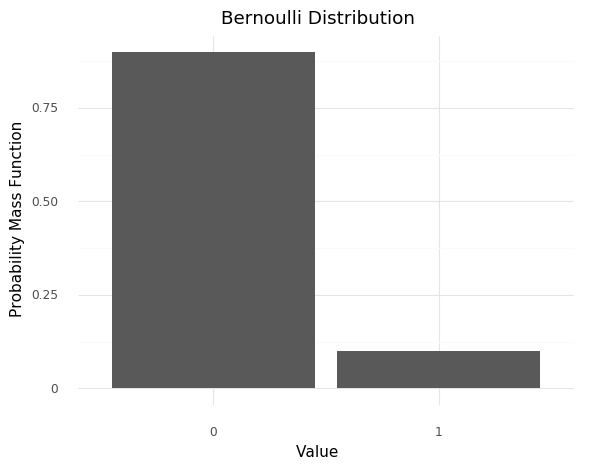

<ggplot: (8769549250943)>

In [25]:
flips = np.random.choice([0,1], size=n, p=[1-p,p])
flips_df = pd.DataFrame(flips)
flips_df.columns = ['conv_flag']
g = (ggplot(flips_df,aes(x='factor(conv_flag)')) + geom_bar(aes(y = '(..count..)/sum(..count..)'))  + 
    theme_minimal() + xlab('Value') + ylab('Probability Mass Function') +
    ggtitle(f'Bernoulli Distribution'))
g

**Continuous probability distribution** contains values that can take infinitely many, uncountable values (for instance, all real numbers between 0 and 1). Since there are infinitely many values, the probability of each individual value is essentially zero (what are the chance of winning the lottery that has infinite number of digits). Therefore, instead of the exact probability of each value (probability mass function), the Y-axis only represents the **probability density function**. This can be thought of as the total probability within an immeasurably small interval around the value. Take an example of a normal distribution with expectation $\mu=0$ and variance $\sigma^2=0.01$. The probability density function of the value 0 is described as:

\begin{align}
f(x) &= \frac{1}{\sqrt{2\pi\sigma^2}} e^{\frac{-(x-\mu)^2}{2\sigma^2}}\\
&= \frac{1}{\sqrt{2\pi(0.01)}} e^{\frac{-(x-0)^2}{2(0.01)}} \text{; }\mu=0;\sigma^2=0.01 \\
&\approx 3.989 \text{; when } x=0
\end{align}

This of course does not mean that there is 398.9% chance that we will draw the value 0 but the density of the probability around the value. The actual probability of that interval around 0 is 3.989 times an immeasurably small number which will be between 0 and 1.

Intuitively, we can think of these intervals as start from relatively large numbers such as 0.1 and gradually decreases to smaller numbers such as 0.005. As you can see from the plot below, the plot becomes more fine-grained and looks more "normal" as the intervals get smaller.

In [26]:
def prob_density(step,mu=0,sigma=0.1):
    x = np.arange(-0.5, 0.5, step)
    y = np.array([sp.stats.norm.pdf(i, loc=mu, scale=sigma) for i in x])

    sm_df = pd.DataFrame({'x': x, 'y': y})
    g = (ggplot(sm_df, aes(x='x', y='y')) + geom_bar(stat='identity') +
          theme_minimal() + xlab('Value') + ylab('Probability Density Function') + 
          ggtitle(f'Normal Distribution with Expectation={mu} and Variance={sigma**2:2f}')) 
    g.draw()
    
interact(prob_density, step=widgets.FloatSlider(min=5e-3,max=1e-1,value=1e-1,step=1e-3,readout_format='.3f'))

interactive(children=(FloatSlider(value=0.1, description='step', max=0.1, min=0.005, readout_format='.3f', ste…

<function __main__.prob_density(step, mu=0, sigma=0.1)>